# Analysis of the response data

In [1]:
!which python

/Users/apartin/anaconda3/envs/cell-drug-sens/bin/python


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# Utils
file_path = os.getcwd()  # os.path.dirname(os.path.relpath(__file__))
utils_path = os.path.abspath(os.path.join(file_path, '../src/train'))
sys.path.append(utils_path)

# import utils_models

In [3]:
DATADIR = '/Users/apartin/work/jdacs/Benchmarks/Data/Pilot1'
OURDIR = os.path.join(file_path, 'rsp_data')
os.makedirs(OURDIR, exist_ok=True)

In [4]:
target_name = 'AUC'

In [5]:
# Load chem-partner rsp dataset
rspc = pd.read_csv(os.path.join(DATADIR, 'ChemPartner_single_response_agg'), sep='\t')
rspc['SOURCE'] = rspc['SOURCE'].map(lambda s: s.lower())
print(rspc.shape)
display(rspc.groupby('SOURCE').agg({'CELL': 'nunique', 'DRUG': 'nunique'}).reset_index())
display(rspc[:2])

(1028, 14)


,SOURCE,CELL,DRUG
0,chempartner_b01,9,15
1,chempartner_b02,40,24


,SOURCE,CELL,DRUG,STUDY,AUC,IC50,EC50,EC50se,R2fit,Einf,HS,AAC1,AUC1,DSS1
0,chempartner_b01,NCI60.BT-549,NSC.122758,fake_exp,0.8384,NaN,6.268,0.0538,0.9822,0.5727,1.142,0.3689,0.6311,0.2987
1,chempartner_b01,NCI60.BT-549,NSC.180973,fake_exp,0.7750,NaN,7.192,0.0502,0.9775,0.5770,1.885,0.3740,0.6260,0.3044


In [6]:
# Load combined rsp dataset
rsp = pd.read_csv(os.path.join(DATADIR, 'combined_single_response_agg'), sep='\t')
rsp['SOURCE'] = rsp['SOURCE'].map(lambda s: s.lower())
print(rsp.shape)
display(rsp.groupby('SOURCE').agg({'CELL': 'nunique', 'DRUG': 'nunique'}).reset_index())
display(rsp[:2])

(4484081, 14)


,SOURCE,CELL,DRUG
0,ccle,504,24
1,ctrp,887,544
2,gcsi,409,16
3,gdsc,1075,249
4,nci60,59,52671
5,scl,65,445
6,sclc,70,526


,SOURCE,CELL,DRUG,STUDY,AUC,IC50,EC50,EC50se,R2fit,Einf,HS,AAC1,AUC1,DSS1
0,ccle,CCLE.1321N1,CCLE.1,fake_exp,0.8330,4.883,5.183,0.5746,0.9864,0.2017,0.7463,0.1017,0.8983,0.0551
1,ccle,CCLE.1321N1,CCLE.10,fake_exp,0.7909,5.217,5.217,2.2840,0.6526,0.0000,0.8993,0.1136,0.8864,0.0728


In [13]:
# Drop na values
rsp = rsp[~rsp[target_name].isna()]
rspc = rspc[~rspc[target_name].isna()]

## Compare rsp distributions across studies

In [14]:
rsp.iloc[:2,:]

,SOURCE,CELL,DRUG,STUDY,AUC,IC50,EC50,EC50se,R2fit,Einf,HS,AAC1,AUC1,DSS1
0,ccle,CCLE.1321N1,CCLE.1,fake_exp,0.8330,4.883,5.183,0.5746,0.9864,0.2017,0.7463,0.1017,0.8983,0.0551
1,ccle,CCLE.1321N1,CCLE.10,fake_exp,0.7909,5.217,5.217,2.2840,0.6526,0.0000,0.8993,0.1136,0.8864,0.0728


0 ccle
1 ctrp
2 gdsc
3 nci60
4 scl
5 sclc
6 gcsi


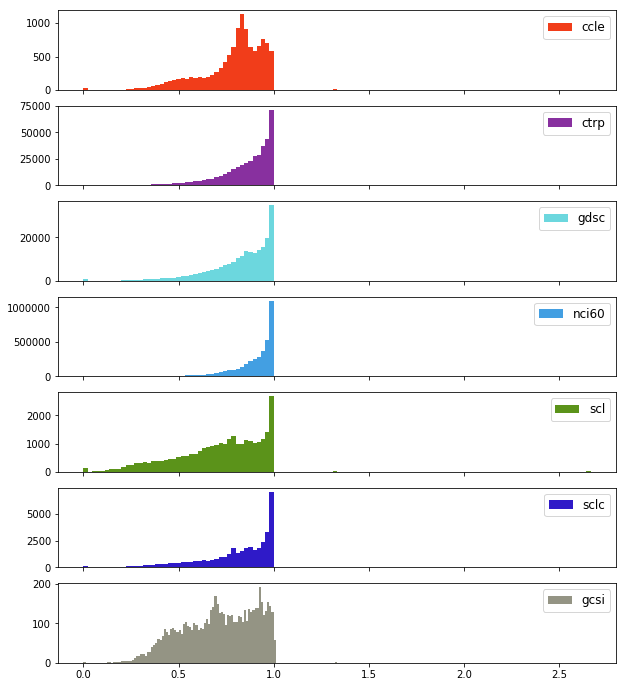

In [16]:
df = rsp.copy()

fig, ax = plt.subplots(len(df['SOURCE'].unique()), 1, sharex=True, figsize=(10, 12))
ax = ax.ravel()
for i, src_name in enumerate(df['SOURCE'].unique()):
    y = df[df['SOURCE']==src_name][target_name].copy()
    ax[i].hist(y, bins=120, label=src_name, color=np.random.rand(3))
    # sns.distplot(v.values, bins=100, kde=False, label=src, ax=ax[i], color='b')
    ax[i].legend(loc='upper right', fontsize=12)
    # ax[i].set_xlim([-0.02, 1.02])

### 1. CTRP (find appropriate tfrm)

In [38]:
ctrp = df[df['SOURCE']=='ctrp'][target_name].reset_index(drop=True).copy()
print((ctrp < 0).sum())
print((ctrp > 1).sum())

0
273


In [39]:
# Keep in values 
ymin, ymax = 0, 1
y = ctrp[(ctrp >= ymin) & (ctrp <= ymax)].copy()

In [53]:
# Generate dict of tfms of y
pwr_vec = [2, 3, 4, 5]
tfms = {}
for pwr in pwr_vec:
    y_tfm = y ** pwr
    tfms[pwr] = y_tfm

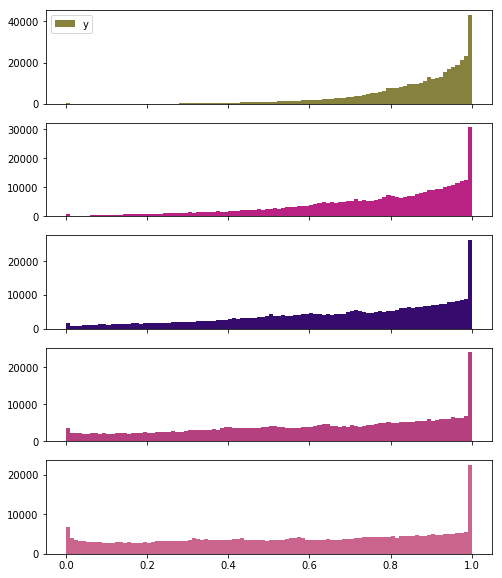

In [57]:
fig, ax = plt.subplots(len(pwr_vec)+1, 1, sharex=True, figsize=(8, 10))
ax = ax.ravel()
ax[0].hist(y, 100, label='y',  color=np.random.rand(3)); ax[0].legend(loc='best');
for i, (pwr, y_tfm) in enumerate(tfms.items()):    
    ax[i+1].hist(y_tfm, 100, label=str(pwr),  color=np.random.rand(3)); ax[0].legend(loc='best');

## Transform the target

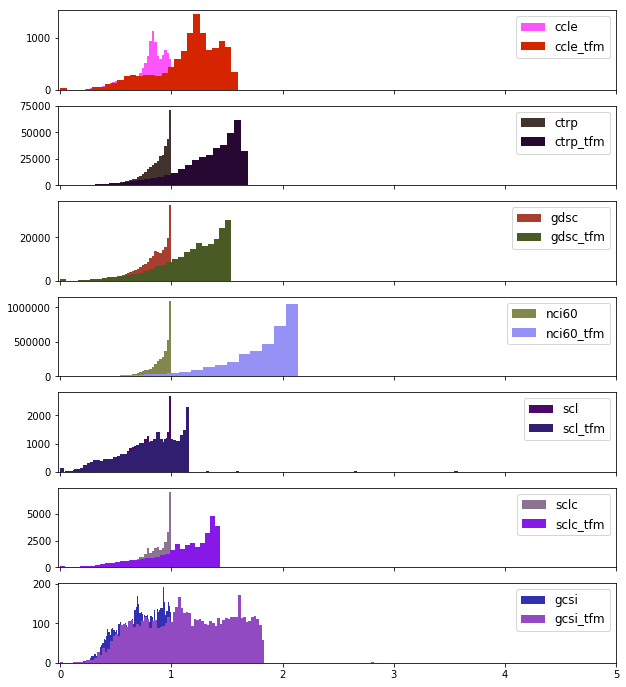

In [41]:
df = rsp.copy()
lmbda_dict = {}

fig, ax = plt.subplots(len(df['SOURCE'].unique()), 1, sharex=True, figsize=(10, 12))
ax = ax.ravel()
for i, src_name in enumerate(df['SOURCE'].unique()):
    y = df[df['SOURCE']==src_name][target_name].copy()
    ax[i].hist(y, bins=120, label=src_name, color=np.random.rand(3))
    
    # Transform using boxcox
    y_tfm, lmbda = stats.boxcox(y + 1);
    ax[i].hist(y_tfm, bins=120, label=src_name + '_tfm', color=np.random.rand(3))
    lmbda_dict[src_name] = lmbda
    # sns.distplot(v.values, bins=100, kde=False, label=src, ax=ax[i], color='b')
    
    ax[i].legend(loc='upper right', fontsize=12)
    ax[i].set_xlim([-0.02, 5])

## Find common drugs between chempartner and other studies

In [ ]:
# Chem-partner drugs
# print(rspc['DRUG'].unique())
val_cnt = pd.Series(rspc['DRUG'].unique()).map(lambda s: s.split('.')[0]).value_counts()
display(val_cnt)

# Plot
fig, ax = plt.subplots(figsize=(5, 2))
rects = ax.barh(val_cnt.index, val_cnt.values, color='b', alpha=0.7);
ax.set_title('Drugs in ChemPartner')
ax.set_xlabel('Num of unique drugs', fontsize=12)
ax.set_xlim([0, 25])
for i, n in enumerate(val_cnt.values):
    # https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.text.html
    # https://matplotlib.org/gallery/pyplots/text_layout.html#sphx-glr-gallery-pyplots-text-layout-py
    ax.text(x=n+0.3, y=i-0.1, s=str(n), color='k', fontsize=12)

In [9]:
def func(rsp, rspc, target_name):
    """ Combines rsp data from cellline studies and chempartner. """
    # Drop NA values
    rsp = rsp[~(rsp[target_name].isna())]
    rspc = rspc[~(rspc[target_name].isna())]
    
    # Extract cols of interest
    cols = ['SOURCE', 'CELL', 'DRUG'] + [target_name]
    rsp = rsp[cols].copy()
    rspc = rspc[cols].copy()
    
    # Merge dfs
    rsp = pd.merge(rspc[['DRUG']], rsp, on='DRUG') # suffixes=('_chem', '_comb'))

    # Make sure the dfs have the order of columns
    rsp = rsp[cols]
    rspc = rspc[cols]
    
    # Add another SOURCE col
    # assign single label for the entire chemp dataset
    rspc.insert(loc=1, column='SOURCE_', value=rspc['SOURCE'].map(lambda s: s.split('_')[0]))
    rsp.insert(loc=1, column='SOURCE_', value=rsp['SOURCE'])
    
    df = pd.concat([rspc, rsp], axis=0)
    return df

In [11]:
df = func(rsp=rsp, rspc=rspc, target_name=target_name)

In [12]:
df.groupby('SOURCE_').agg({'SOURCE': 'unique', 'CELL': 'nunique', 'DRUG': 'nunique'}).reset_index()

,SOURCE_,SOURCE,CELL,DRUG
0,chempartner,"[chempartner_b01, chempartner_b02]",49,39
1,ctrp,[ctrp],887,22
2,gdsc,[gdsc],1045,2
3,nci60,[nci60],59,15
4,scl,[scl],65,14
5,sclc,[sclc],70,14


In [13]:
# utils_models.plot_density(df=df, col=target_name, split_by='SOURCE_',
#                           kind='kde', bins=100, figsize=(12, 5), title=None, outpath=None)

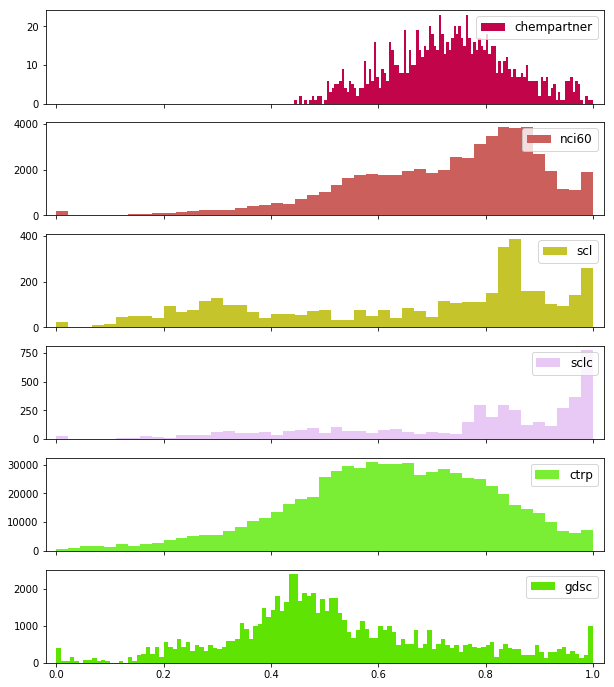

In [14]:
fig, ax = plt.subplots(len(df['SOURCE_'].unique()), 1, sharex=True, figsize=(10, 12))
ax = ax.ravel()
for i, src in enumerate(df['SOURCE_'].unique()):
    v = df[df['SOURCE_'] == src][target_name].copy()
    ax[i].hist(v, bins=120, label=src, color=np.random.rand(3))
    # sns.distplot(v.values, bins=100, kde=False, label=src, ax=ax[i], color='b')
    ax[i].legend(loc='upper right', fontsize=12)
    ax[i].set_xlim([-0.02, 1.02])

In [15]:
# Intersection of unique drugs
len(set(rspc['DRUG']).intersection(set(rsp['DRUG'])))

39

In [46]:
# plt.hist(rsp['AUC'], bins=100); plt.grid();

In [47]:
# plt.hist(rsp['AUC1'], bins=100); plt.grid()

In [48]:
# rsp = rsp[rsp['SOURCE']=='CCLE']
# print(rsp.shape)

In [49]:
# plt.hist(rsp['AUC'], bins=100); plt.grid()

In [50]:
# plt.hist(rsp['AUC1'], bins=100); plt.grid()

In [51]:
rsp = rsp[rsp.SOURCE=='CCLE']
rsp['CELL'] = rsp['CELL'].map(lambda s: ''.join([x for i, x in enumerate(s.split('.')) if i>0]))
display(rsp[:2])

,SOURCE,CELL,DRUG,STUDY,AUC,IC50,EC50,EC50se,R2fit,Einf,HS,AAC1,AUC1,DSS1
0,CCLE,1321N1,CCLE.1,fake_exp,0.8330,4.883,5.183,0.5746,0.9864,0.2017,0.7463,0.1017,0.8983,0.0551
1,CCLE,1321N1,CCLE.10,fake_exp,0.7909,5.217,5.217,2.2840,0.6526,0.0000,0.8993,0.1136,0.8864,0.0728


In [59]:
dfp, meta = utils.load_lincs1000(dataset='raw', sources=['CCLE'], verbose=False)
dfp.rename(columns={'Sample': 'CELL'}, inplace=True)
dfp['CELL'] = dfp['CELL'].map(lambda s: ''.join([x for i, x in enumerate(s.split('.')) if i>0])) 
dfp[:2]

,CELL,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,22RV1,8.31,7.17,4.12,5.64,6.04,3.94,2.08,5.24,5.23,...,3.22,4.85,4.46,3.98,4.77,1.58,3.90,4.19,3.88,5.37
1,2313287,8.94,6.30,3.83,6.60,5.99,6.34,3.72,4.67,5.78,...,3.86,4.80,4.72,4.13,4.03,1.00,3.97,3.82,3.78,5.49


In [60]:
dfp = pd.merge(dfp, rsp[['CELL']].drop_duplicates(), on='CELL', how='inner')
print(dfp.shape)
dfp[:2]

,CELL,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,22RV1,8.31,7.17,4.12,5.64,6.04,3.94,2.08,5.24,5.23,...,3.22,4.85,4.46,3.98,4.77,1.58,3.90,4.19,3.88,5.37
1,42MGBA,7.84,6.72,3.09,6.92,5.43,5.38,3.99,5.85,5.17,...,5.48,3.04,4.95,4.79,3.52,1.24,3.08,2.44,2.10,5.65


In [62]:
rsp = pd.merge(rsp[['CELL']], dfp, on='CELL', how='inner')
print(rsp.CELL.nunique())
print(rsp.shape)
rsp[:2]

474
(10971, 943)


,CELL,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,22RV1,8.31,7.17,4.12,5.64,6.04,3.94,2.08,5.24,5.23,...,3.22,4.85,4.46,3.98,4.77,1.58,3.9,4.19,3.88,5.37
1,22RV1,8.31,7.17,4.12,5.64,6.04,3.94,2.08,5.24,5.23,...,3.22,4.85,4.46,3.98,4.77,1.58,3.9,4.19,3.88,5.37


In [64]:
dfr = pd.read_csv(os.path.join(file_path, 'ccle_preproc/qdata_ccle_vsd.txt'), sep='\t')
dfr.columns = [c.split('_')[0] for c in dfr.columns]
dfr = dfr[sorted(dfr.columns)]
dfr = dfr.T.reset_index().rename(columns={'index': 'CELL'})
print(dfr.shape)
dfr[:2]

(472, 979)


,CELL,ENSG00000198804,ENSG00000198712,ENSG00000156508,ENSG00000111640,ENSG00000198763,ENSG00000075624,ENSG00000198727,ENSG00000198786,ENSG00000096384,...,ENSG00000100632,ENSG00000123505,ENSG00000148358,ENSG00000162923,ENSG00000171603,ENSG00000136261,ENSG00000133872,ENSG00000086232,ENSG00000100804,ENSG00000183207
0,22RV1,20.788581,19.751415,19.013754,18.593386,18.984787,17.933823,19.312850,18.962841,17.656763,...,11.123309,16.645011,12.902036,12.209317,13.273013,13.372718,13.709679,13.470386,12.568330,12.156382
1,42MGBA,19.169135,19.516331,19.040697,19.163827,18.326890,19.660023,18.419892,18.065109,17.675745,...,12.826239,13.911053,11.845961,10.969848,12.838236,13.463158,13.129023,12.502801,13.856113,13.324501


In [65]:
print(dfp.shape)
print(dfr.shape)

(474, 943)
(472, 979)


In [68]:
print(set(dfp.CELL.tolist()).difference(set(dfr.CELL.tolist())))
print(set(dfr.CELL.tolist()).difference(set(dfp.CELL.tolist())))

{'HS840T', 'HS895T', 'HS739T', 'RKN', 'HS229T'}
{'COLO699', 'COV504', 'OC316'}


In [70]:
(dfp.CELL=='HS840T').sum()

1

# EDA

In [171]:
rsp = pd.read_csv(os.path.join(DATADIR, 'combined_single_response_agg'), sep='\t')
rsp = rsp[['SOURCE', 'CELL', 'DRUG', 'AUC', 'AUC1', 'IC50']]
print(rsp.shape)
rsp[:2]

(4484081, 6)


,SOURCE,CELL,DRUG,AUC,AUC1,IC50
0,CCLE,CCLE.1321N1,CCLE.1,0.8330,0.8983,4.883
1,CCLE,CCLE.1321N1,CCLE.10,0.7909,0.8864,5.217


In [172]:
rsp.groupby('SOURCE').agg({'CELL': 'nunique'}).reset_index()

,SOURCE,CELL
0,CCLE,504
1,CTRP,887
2,GDSC,1075
3,NCI60,59
4,SCL,65
5,SCLC,70
6,gCSI,409


In [173]:
# load_drug_info()
path = os.path.join(DATADIR, 'drug_info')
df_info = pd.read_table(path, dtype=object)
df_info['PUBCHEM'] = 'PubChem.CID.' + df_info['PUBCHEM']
df_info['Drug'] = df_info['PUBCHEM']
print(df_info.shape)

df_info['SOURCE'] = df_info['ID'].map(lambda x: x.split('.')[0])  # (ap)
df_info.drop(columns=['Drug'], inplace=True)
df_info.rename(columns={'ID': 'DRUG'}, inplace=True)

df_info[:2]

(846, 7)


,DRUG,NAME,CLEAN_NAME,SMILES,INCHIKEY,PUBCHEM,SOURCE
0,CCLE.1,AEW541,AEW541,C1CN(C1)CC2CC(C2)N3C=C(C4=C3N=CN=C4N)C5=CC(=CC...,AECDBHGVIIRMOI-UHFFFAOYSA-N,PubChem.CID.11476171,CCLE
1,CCLE.10,ZD-6474,ZD6474,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,UHTHHESEBZOYNR-UHFFFAOYSA-N,PubChem.CID.3081361,CCLE


In [174]:
df_info.groupby('SOURCE').agg({'DRUG': 'nunique'}).reset_index()

,SOURCE,DRUG
0,CCLE,24
1,CTRP,544
2,GDSC,262
3,gCSI,16


In [175]:
print(df_info[['DRUG', 'NAME', 'CLEAN_NAME']].shape)
print(rsp.shape)

(846, 3)
(4484081, 6)


In [176]:
rsp = pd.merge(df_info[['DRUG', 'NAME', 'CLEAN_NAME']], rsp, on='DRUG', how='inner')
print(rsp.shape)

(637089, 8)


In [177]:
rsp.groupby('SOURCE').agg({'DRUG': 'nunique'}).reset_index()

,SOURCE,DRUG
0,CCLE,24
1,CTRP,544
2,GDSC,247
3,gCSI,16


In [178]:
df, meta = utils.load_lincs1000(dataset='raw', sources=['ccle', 'ctrp', 'gdsc', 'gcsi', 'nci60'])
meta = meta[['Sample', 'source', 'core_str', 'csite', 'ctype', 'simplified_csite', 'simplified_ctype']]
meta.rename(columns={'Sample': 'CELL'}, inplace=True)


Dataset: combined_rnaseq_data_lincs1000
df_rna (2917, 943)
meta   (2917, 20)
CCLE     1018
CTRP      812
GDSC      670
gCSI      357
NCI60      60
Name: Sample, dtype: int64


In [179]:
meta.nunique()

CELL                2917
source                 5
core_str            1039
csite                 27
ctype                 66
simplified_csite      15
simplified_ctype      17
dtype: int64

In [180]:
df = pd.merge(rsp, meta, on='CELL', how='inner')
print(df.shape)
df[:2]

(519968, 14)


,DRUG,NAME,CLEAN_NAME,SOURCE,CELL,AUC,AUC1,IC50,source,core_str,csite,ctype,simplified_csite,simplified_ctype
0,CCLE.1,AEW541,AEW541,CCLE,CCLE.22RV1,0.7153,0.7760,5.66,ccle,22Rv1,prostate,Prostate Adenocarcinoma,prostate,prostate
1,CCLE.10,ZD-6474,ZD6474,CCLE,CCLE.22RV1,0.9579,0.9541,NaN,ccle,22Rv1,prostate,Prostate Adenocarcinoma,prostate,prostate


In [181]:
df.groupby('SOURCE').agg({'CELL': 'nunique'}).reset_index()

,SOURCE,CELL
0,CCLE,474
1,CTRP,812
2,GDSC,670
3,gCSI,357


In [ ]:
data = df.groupby(['simplified_ctype', 'DRUG']).agg({})